<a href="https://colab.research.google.com/github/oliviaxyl/Sentiment-Analysis-of-Amazon-Kindle-Reviews-/blob/master/Kindle_Review_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Runtime ==> Change runtime type ==> Hardware accelerator ==> GPU

import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.1MB 8.2MB/s 
     |████████████████████████████████| 1.1MB 31.7MB/s 
     |████████████████████████████████| 3.0MB 57.5MB/s 
     |████████████████████████████████| 890kB 51.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=5fd43af5b7f24095674b5c62f2683abb3ff9ecdc63e3e497cff4f27ef296b6e9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Kindle Reviews/kindle_reviews.csv')# Drop missing review 

In [ ]:
df.dropna(subset=['reviewText'], inplace=True)
df = df.sample(frac=.05, random_state=999).reset_index()
df = df[['reviewText','summary','overall']]
df['reviewText'] = df['reviewText'] + df['summary']
df.drop('summary', axis=1, inplace=True)

df['overall'].value_counts()

5    28583
4    12826
3     4859
2     1682
1     1180
Name: overall, dtype: int64

In [ ]:
# 3 classes - Negative, Neutral, Positive

import numpy as np

# convert ratings to sentiments
def rating_to_sentiment(reviews):
    reviews['sentiment'] = ""
    for i in range(len(reviews)):
        if (reviews['overall'][i] == 1 or reviews['overall'][i] == 2):
            reviews['sentiment'][i] = 'Negative'
        elif (reviews['overall'][i] == 3):
            reviews['sentiment'][i] = 'Neutral'
        else:
            reviews['sentiment'][i] = 'Positive'
    return reviews
            
# under-sampling 
def under_sampling(reviews):
    negative = len(reviews[reviews['sentiment'] == 'Negative'])
    under_sample_indices = reviews[reviews.sentiment == 'Negative'].index
    random1 = np.random.choice(reviews[reviews.sentiment == 'Neutral'].index, negative, replace=False)
    random2 = np.random.choice(reviews[reviews.sentiment == 'Positive'].index, negative, replace=False)
    under_sample_indices = np.concatenate([under_sample_indices, random1, random2])
    reviews_under_sample = reviews.loc[under_sample_indices].reset_index(drop=True)
    reviews_under_sample.drop('overall',axis=1, inplace=True)
    return reviews_under_sample

def balanced_classification(reviews):
    reviews = rating_to_sentiment(reviews)
    reviews_under_sample = under_sampling(reviews)
    return reviews_under_sample

In [ ]:
reviews_under_sample = balanced_classification(df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
reviews_under_sample['sentiment'].unique()

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [ ]:
def number_of_class(reviews_under_sample, k):
  # 3 classes - Negative, Neutral, Positive
  if k == 3:
    reviews_under_sample.replace({'Negative':0,'Neutral':1,'Positive':2},inplace=True)
    reviews_under_sample = reviews_under_sample.sample(frac=1, random_state = 233).reset_index(drop=True)
  elif k == 2:
    # 2 classes - Negative, Positive
    reviews_under_sample = reviews_under_sample.drop(reviews_under_sample[reviews_under_sample['sentiment']=='Neutral'].index, axis=0)
    reviews_under_sample.replace({'Negative':0,'Positive':1},inplace=True)
    reviews_under_sample = reviews_under_sample.sample(frac=1, random_state = 233).reset_index(drop=True)
  else:
    print('Error : --- Group Input Should Be In (2,3) ---')

  # Get the lists of sentences and their labels.
  sentences = reviews_under_sample.reviewText.values
  labels = reviews_under_sample.sentiment.values

  return sentences, labels

In [ ]:
sentences, labels = number_of_class(reviews_under_sample,3)

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  I enjoyed this short(very  short)story. Just as you were getting into it,it ended . A little more mystery and another murder would have been great . All in all a great readThe Island Murder
Tokenized:  ['i', 'enjoyed', 'this', 'short', '(', 'very', 'short', ')', 'story', '.', 'just', 'as', 'you', 'were', 'getting', 'into', 'it', ',', 'it', 'ended', '.', 'a', 'little', 'more', 'mystery', 'and', 'another', 'murder', 'would', 'have', 'been', 'great', '.', 'all', 'in', 'all', 'a', 'great', 'read', '##the', 'island', 'murder']
Token IDs:  [1045, 5632, 2023, 2460, 1006, 2200, 2460, 1007, 2466, 1012, 2074, 2004, 2017, 2020, 2893, 2046, 2009, 1010, 2009, 3092, 1012, 1037, 2210, 2062, 6547, 1998, 2178, 4028, 2052, 2031, 2042, 2307, 1012, 2035, 1999, 2035, 1037, 2307, 3191, 10760, 2479, 4028]


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        pad_to_max_length = True, 
                        max_length = 256,
                        truncation = True,
                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 256

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I enjoyed this short(very  short)story. Just as you were getting into it,it ended . A little more mystery and another murder would have been great . All in all a great readThe Island Murder
Token IDs: [101, 1045, 5632, 2023, 2460, 1006, 2200, 2460, 1007, 2466, 1012, 2074, 2004, 2017, 2020, 2893, 2046, 2009, 1010, 2009, 3092, 1012, 1037, 2210, 2062, 6547, 1998, 2178, 4028, 2052, 2031, 2042, 2307, 1012, 2035, 1999, 2035, 1037, 2307, 3191, 10760, 2479, 4028, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# Use 80% for training and 10% for validation, 10% for testing.

from sklearn.model_selection import train_test_split

train_inputs, temp_inputs, train_labels, temp_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.2)

validation_inputs, test_inputs, validation_labels, test_labels = train_test_split(temp_inputs, temp_labels, 
                                                            random_state=2018, test_size=0.5)

# Do the same for the masks.
train_masks, temp_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.2)

validation_masks, test_masks, _, _ = train_test_split(temp_masks, temp_labels,
                                             random_state=2018, test_size=0.5)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

def model_classification(k):
  # Load BertForSequenceClassification, the pretrained BERT model with a single 
  # linear classification layer on top. 
  model = BertForSequenceClassification.from_pretrained(
      "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = k, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
      output_attentions = False, # Whether the model returns attentions weights.
      output_hidden_states = False, # Whether the model returns all hidden-states.
  )
  return model

In [ ]:
model = model_classification(3)
  # Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

import random
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    215.    Elapsed: 0:00:56.
  Batch    80  of    215.    Elapsed: 0:01:55.
  Batch   120  of    215.    Elapsed: 0:02:54.
  Batch   160  of    215.    Elapsed: 0:03:53.
  Batch   200  of    215.    Elapsed: 0:04:53.

  Average training loss: 0.71
  Training epcoh took: 0:05:15

Running Validation...
  Accuracy: 0.74
  Validation took: 0:00:15

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    215.    Elapsed: 0:00:59.
  Batch    80  of    215.    Elapsed: 0:01:59.
  Batch   120  of    215.    Elapsed: 0:02:58.
  Batch   160  of    215.    Elapsed: 0:03:58.
  Batch   200  of    215.    Elapsed: 0:04:57.

  Average training loss: 0.48
  Training epcoh took: 0:05:19

Running Validation...
  Accuracy: 0.74
  Validation took: 0:00:15

======== Epoch 3 / 5 ========
Training...
  Batch    40  of    215.    Elapsed: 0:00:59.
  Batch    80  of    215.    Elapsed: 0:01:59.
  Batch   120  of    215.    Elapsed: 0:02:58.
  

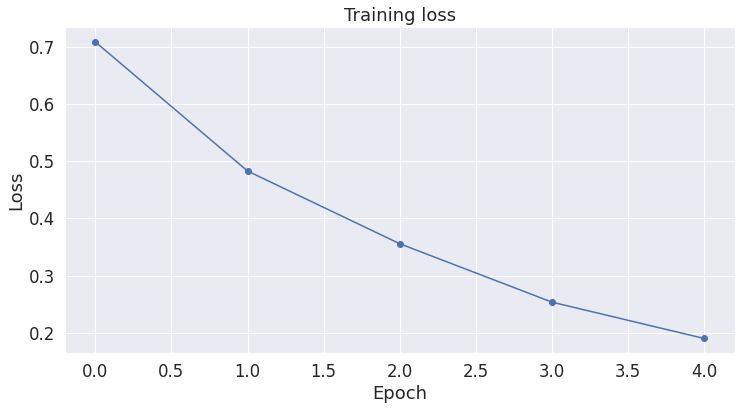

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 859 test sentences...
    DONE.


In [ ]:
pred_labels = []
# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 3-column ndarray (two columns for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  pred_labels.append(pred_labels_i)

true_label = 0
for i in range(len(pred_labels)):
  for j in range(len(pred_labels[i])):
    if pred_labels[i][j] == true_labels[i][j]:
      true_label += 1 

print('The test accuracy is {}%'.format(round(true_label/len(test_inputs),4)*100)) 

The test accuracy is 76.72%


In [ ]:
# Reference:

# Transfer Learning for NLP: Fine-Tuning BERT for Text Classification
# https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/

# Multi Class Text Classification With Deep Learning Using BERT
# https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613

# A Visual Guide to Using BERT for the First Time
# http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

# Tokenizers: How machines read 
# https://blog.floydhub.com/tokenization-nlp/

# 3 subword algorithms help to improve your NLP model performance
# https://medium.com/@makcedward/how-subword-helps-on-your-nlp-model-83dd1b836f46

# Text preprocessing for BERT
# https://www.kaggle.com/c/google-quest-challenge/discussion/127881

# The Illustrated Transformer
# http://jalammar.github.io/illustrated-transformer/

# BERT Fine-Tuning Sentence Classification
# https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=nSU7yERLP_66

# BERT Explained – A list of Frequently Asked Questions
# https://yashuseth.blog/2019/06/12/bert-explained-faqs-understand-bert-working/

